In [304]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)


In [320]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def get_matern_five_half(rho):
    def k(x,y):
        d=jnp.sqrt(jnp.sum((x-y)**2))
        return (1+jnp.sqrt(5)*d/rho+jnp.sqrt(5)*d**2/(rho**2))*jnp.exp(-jnp.sqrt(5)*d/rho)
    return k

def div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.05)

k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None, 0)), in_axes=(0, None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None, 0)), in_axes=(0, None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None, 0)), in_axes=(0, None))

def true_solution_single(x):
    boundary_term = x[0]*(1-x[0])*x[1]*(1-x[1])
    interior = jnp.cos(5*jnp.pi*((0.5-x[0])**2 + (0.3*x[1])**2))
    return 10*boundary_term * interior

true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
rhs_func = jit(jax.vmap(lambda u:laplacian(true_solution_single)(u)+true_solution_single(u)**2))

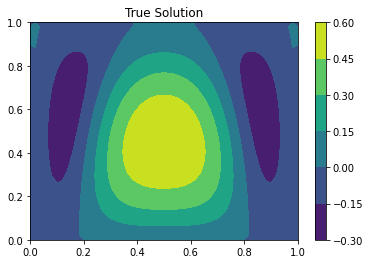

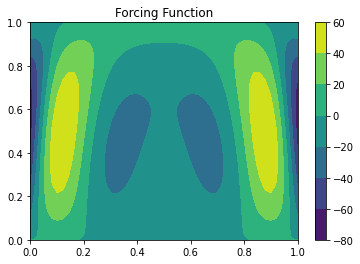

In [321]:
m_interp=50
xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
meshX,meshY=np.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([meshX.flatten(),meshY.flatten()]).T

interp_solution=(true_solution(interpolation_points)).reshape(m_interp,m_interp)
interp_rhs=(rhs_func(interpolation_points)).reshape(m_interp,m_interp)

plt.title("True Solution")
plt.contourf(meshX,meshY,interp_solution)
plt.colorbar()
plt.show()
plt.title("Forcing Function")
plt.contourf(meshX,meshY,interp_rhs)
plt.colorbar()
plt.show()

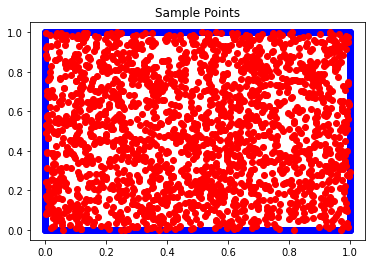

In [326]:
num_interior=2000
num_per_boundary=500

num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [327]:
Klaplap = vec_k_laplap(interior_points,interior_points) #Contribution from interior laplacian nodes to laplacian of output
K_xx = vec_k(interior_points,interior_points) #Contribution from interior points to interior points
K_lap_x = vec_k_lapx(interior_points,interior_points) #Contribution from interior points to laplacian
Klap_boundary = vec_k_lapx(interior_points,boundary_points) #Contribution from nodes at the boundary to points in interior
K_x_boundary = vec_k(interior_points,boundary_points)
K_BB = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [Klaplap,K_lap_x,Klap_boundary],
        [K_lap_x.T,K_xx,K_x_boundary],
        [Klap_boundary.T,K_x_boundary.T,K_BB]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

In [328]:
nugget=1e-4
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))


def residual(coef):
    func_outputs=K_full@coef

    lapvals=func_outputs[:num_interior]
    funcvals=func_outputs[num_interior:2*num_interior]
    equation_vals = lapvals + funcvals**2
    boundary_vals = func_outputs[-num_boundary:]
    return rhs_total - jnp.hstack([equation_vals,boundary_vals])

lam=1e-4
def loss(coef):
    return (1/2)*jnp.sum(residual(coef)**2)+1/2*lam*coef@Kmat@coef

lossgrad=grad(loss)

losshessian=hessian(loss)

In [329]:
c=jnp.zeros(len(K_full))
for i in range(20):
    c=c-jnp.linalg.solve(losshessian(c),lossgrad(c))

    print(f"{i}:Loss",loss(c))
    print(f"{i}Residual norm squared",jnp.sum(residual(c)**2))

0:Loss 52637.06105515585
0Residual norm squared 104547.8536332162
1:Loss 7331.65424229153
1Residual norm squared 14270.048448725775
2:Loss 18742.737723867704
2Residual norm squared 37227.99416031371
3:Loss 148.50933156968847
3Residual norm squared 86.68155555612772
4:Loss 94.60035265732839
4Residual norm squared 2.3893166085676363
5:Loss 94.97127060063691
5Residual norm squared 0.7262659126314059
6:Loss 80.702195551756
6Residual norm squared 0.7945123178960182
7:Loss 96.56425512826904
7Residual norm squared 0.8695395551177953
8:Loss 120.00656943675479
8Residual norm squared 0.7544880640279819
9:Loss 144.51992036122374
9Residual norm squared 0.6795865671644303
10:Loss 133.48295248504982
10Residual norm squared 0.8809022965480948
11:Loss 120.36295649201496
11Residual norm squared 0.629046043820087
12:Loss 138.01909405299776
12Residual norm squared 0.8343869205695487
13:Loss 142.67534518600252
13Residual norm squared 1.0195702477046371
14:Loss 156.6377577962283
14Residual norm squared 0.8

In [330]:
XX,YY=jnp.meshgrid(xgrid,ygrid)
interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_k = jnp.block(
    [
        [
            vec_k_lapx(interpolation_points,interior_points),
            vec_k(interpolation_points,interior_points),
            vec_k(interpolation_points,boundary_points)
            ]
    ]
)


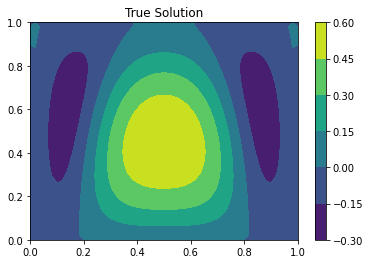

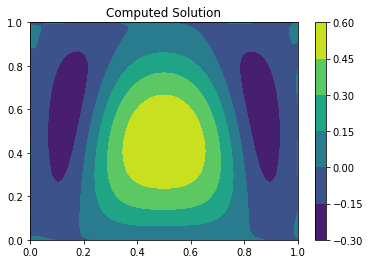

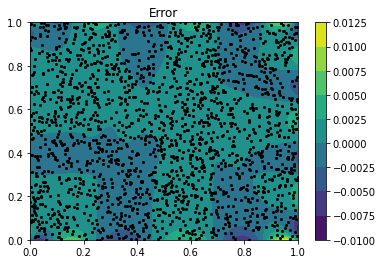

In [331]:
plt.title("True Solution")
plt.contourf(meshX,meshY,interp_solution)
plt.colorbar()
plt.show()

u_interp=(interp_k@c).reshape(m_interp,m_interp)
plt.title("Computed Solution")
plt.contourf(meshX,meshY,u_interp)
plt.colorbar()
plt.show()


plt.title("Error")
plt.contourf(meshX,meshY,interp_solution-u_interp)
plt.colorbar()
plt.scatter(interior_points[:,0],interior_points[:,1],s=4,c='black')
plt.show()

In [332]:
jnp.sqrt(jnp.mean((u_interp-interp_solution)**2))

Array(0.00135421, dtype=float64)

In [333]:
jnp.max(jnp.abs(u_interp-interp_solution))

Array(0.0103278, dtype=float64)